# Anomaly Clustering & Interpretability Analysis

Cluster anomalous traffic patterns detected by baseline models and build interpretable profiles for LLM analysis.

## 1. Load Data and Prepare Top Anomalies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ANOMALY CLUSTERING & INTERPRETABILITY ANALYSIS")
print("="*80)

# Load original data
data_path = "/Users/nawara/Desktop/LLM-Clustering-Paper/Bot-IoT-Dataset/bot_iot_balanced_subset_300k.csv"
df_original = pd.read_csv(data_path, low_memory=False)

# Load baseline predictions
pred_path = "/Users/nawara/Desktop/LLM-Clustering-Paper/baseline_test_predictions.csv"
df_predictions = pd.read_csv(pred_path)

print(f"\nOriginal dataset: {df_original.shape}")
print(f"Test predictions: {df_predictions.shape}")
print(f"Features in predictions: {list(df_predictions.columns)}")

# Use LOF scores (better performance than Isolation Forest)
anomaly_scores = df_predictions['lof_score'].values

print(f"\nLOF Score range: [{anomaly_scores.min():.4f}, {anomaly_scores.max():.4f}]")
print(f"Mean LOF score: {anomaly_scores.mean():.4f}")

ANOMALY CLUSTERING & INTERPRETABILITY ANALYSIS

Original dataset: (150477, 46)
Test predictions: (45144, 5)
Features in predictions: ['actual_label', 'iso_forest_score', 'iso_forest_pred', 'lof_score', 'lof_pred']

LOF Score range: [0.9379, 46.7348]
Mean LOF score: 1.2137


## 2. Select Top K Anomalous Samples

In [6]:
# Select top K anomalous samples by LOF score
# Using top 5,000 samples for interpretable clustering
top_k = 5000

# Sort by LOF anomaly score (higher = more anomalous) and get top K
test_preds_sorted = df_predictions.sort_values('lof_score', ascending=False)
top_anomalies_idx = test_preds_sorted.head(top_k).index

print(f"Selected top {top_k} anomalous samples")
print(f"LOF Score range for selected anomalies: {test_preds_sorted['lof_score'].head(top_k).min():.4f} - {test_preds_sorted['lof_score'].head(top_k).max():.4f}")
print(f"Attack label distribution in top anomalies:\n{test_preds_sorted.head(top_k)['actual_label'].value_counts()}")

# Get the original features for these top anomalous samples
top_anomalies_features = df_original.loc[top_anomalies_idx].copy()
top_anomalies_scores = test_preds_sorted.head(top_k)[['lof_score', 'lof_pred', 'iso_forest_score', 'iso_forest_pred']].copy()

# Merge anomaly scores with features
top_anomalies_data = pd.concat([top_anomalies_features.reset_index(drop=True), 
                                 top_anomalies_scores.reset_index(drop=True)], axis=1)

print(f"\nTop anomalies dataset shape: {top_anomalies_data.shape}")
print(f"Columns: {top_anomalies_data.columns.tolist()}")


Selected top 5000 anomalous samples
LOF Score range for selected anomalies: 1.4412 - 46.7348
Attack label distribution in top anomalies:
actual_label
1    4892
0     108
Name: count, dtype: int64

Top anomalies dataset shape: (5000, 50)
Columns: ['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory', 'lof_score', 'lof_pred', 'iso_forest_score', 'iso_forest_pred']


## 3. Preprocess Anomalies for Clustering

In [8]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Define feature types (using columns that exist)
categorical_features = ['proto', 'state', 'saddr', 'sport', 'daddr', 'dport']
exclude_cols = categorical_features + ['lof_score', 'lof_pred', 'iso_forest_score', 'iso_forest_pred', 'attack', 'category', 'subcategory', 'pkSeqID']

# Identify numeric columns automatically by checking data types
numeric_features = top_anomalies_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in exclude_cols]

print(f"Numeric features ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Load original training data to fit preprocessors (avoid data leakage)
full_data = pd.read_csv('/Users/nawara/Desktop/LLM-Clustering-Paper/Bot-IoT-Dataset/bot_iot_balanced_subset_300k.csv')
X_train = full_data.sample(frac=0.7, random_state=42)

# Fit encoders/scalers on training data only
cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit(X_train[categorical_features])
num_scaler = StandardScaler().fit(X_train[numeric_features].astype(float))

# Transform anomaly features
X_anomalies_cat = cat_encoder.transform(top_anomalies_data[categorical_features])
X_anomalies_num = num_scaler.transform(top_anomalies_data[numeric_features].astype(float))

# Combine features using numpy for speed
X_anomalies_scaled = np.hstack([X_anomalies_num, X_anomalies_cat])

print(f"\nPreprocessed anomalies shape: {X_anomalies_scaled.shape}")
print(f"Ready for clustering with {X_anomalies_scaled.shape[0]} samples and {X_anomalies_scaled.shape[1]} features")

Numeric features (35): ['stime', 'flgs_number', 'proto_number', 'pkts', 'bytes']...
Categorical features (6): ['proto', 'state', 'saddr', 'sport', 'daddr', 'dport']

Preprocessed anomalies shape: (5000, 41)
Ready for clustering with 5000 samples and 41 features


## 4. Determine Optimal Number of Clusters

Computing clustering metrics for k = 3 to 10...
k=3: Inertia=131368391917.96, Silhouette=0.6097
k=4: Inertia=73804970152.25, Silhouette=0.5877
k=5: Inertia=46944650914.65, Silhouette=0.5748
k=6: Inertia=32980194393.49, Silhouette=0.5621
k=7: Inertia=24010704079.49, Silhouette=0.5584
k=8: Inertia=17913684379.71, Silhouette=0.5605
k=9: Inertia=14145881140.63, Silhouette=0.5583
k=10: Inertia=11383496311.61, Silhouette=0.5600


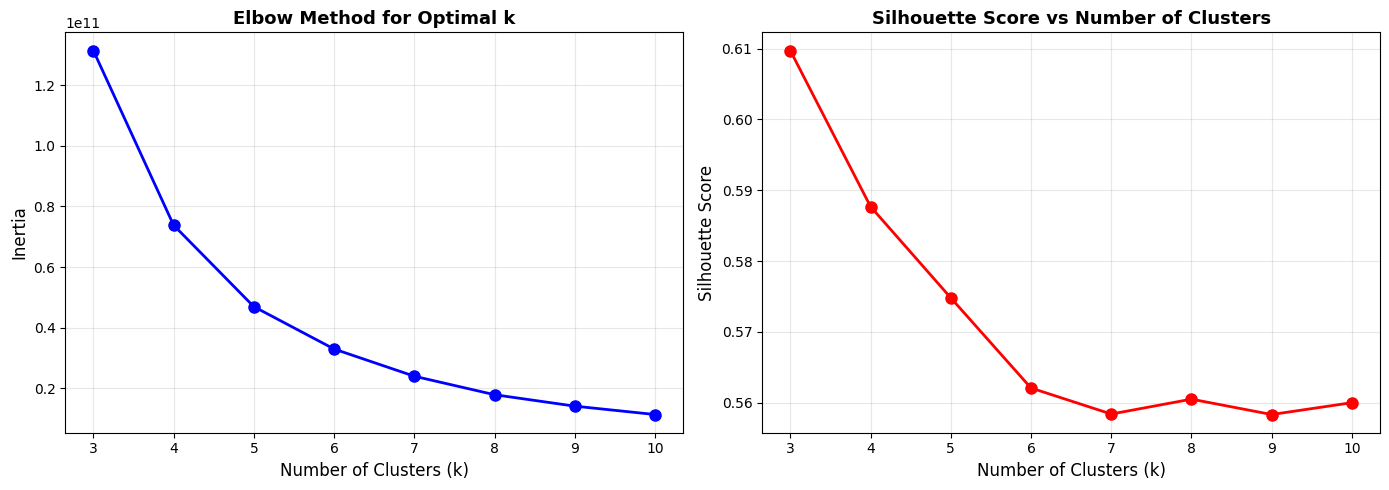


Optimal k (by silhouette): 3 with score 0.6097


In [9]:
# Elbow method + Silhouette analysis to find optimal k
inertias = []
silhouette_scores = []
k_range = range(3, 11)  # Test k from 3 to 10

print("Computing clustering metrics for k = 3 to 10...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_anomalies_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_anomalies_scaled, labels)
    silhouette_scores.append(sil_score)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/nawara/Desktop/LLM-Clustering-Paper/cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Select optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k (by silhouette): {optimal_k} with score {max(silhouette_scores):.4f}")


## 5. Fit K-Means and Generate Cluster Assignments

In [10]:
# Fit final K-Means model with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = final_kmeans.fit_predict(X_anomalies_scaled)

# Add cluster assignments to data
top_anomalies_data['cluster'] = cluster_labels

print(f"K-Means clustering complete with k={optimal_k}")
print(f"\nCluster size distribution:")
print(top_anomalies_data['cluster'].value_counts().sort_index())
print(f"\nCluster distribution (%):")
print((top_anomalies_data['cluster'].value_counts(normalize=True).sort_index() * 100).round(2))


K-Means clustering complete with k=3

Cluster size distribution:
cluster
0    1594
1    1700
2    1706
Name: count, dtype: int64

Cluster distribution (%):
cluster
0    31.88
1    34.00
2    34.12
Name: proportion, dtype: float64


## 6. Build Cluster Profiles (Interpretable Summaries)

In [11]:
# Build comprehensive cluster profiles for LLM interpretation
cluster_profiles = []

for cluster_id in range(optimal_k):
    cluster_data = top_anomalies_data[top_anomalies_data['cluster'] == cluster_id]
    
    profile = {
        'cluster_id': cluster_id,
        'size': len(cluster_data),
        'percentage': f"{(len(cluster_data) / len(top_anomalies_data)) * 100:.2f}%"
    }
    
    # Numeric feature statistics
    profile['numeric_stats'] = {}
    for feat in numeric_features[:5]:  # Show first 5 numeric features
        profile['numeric_stats'][feat] = {
            'mean': cluster_data[feat].mean(),
            'std': cluster_data[feat].std(),
            'min': cluster_data[feat].min(),
            'max': cluster_data[feat].max(),
            'median': cluster_data[feat].median()
        }
    
    # Categorical feature distributions (top 3 categories per feature)
    profile['categorical_dist'] = {}
    for feat in categorical_features:
        top_cats = cluster_data[feat].value_counts().head(3)
        profile['categorical_dist'][feat] = top_cats.to_dict()
    
    # Anomaly score statistics
    profile['lof_score_stats'] = {
        'mean': cluster_data['lof_score'].mean(),
        'median': cluster_data['lof_score'].median(),
        'std': cluster_data['lof_score'].std(),
        'max': cluster_data['lof_score'].max()
    }
    
    # Attack label distribution (for analysis only, not used in clustering)
    profile['attack_distribution'] = cluster_data['attack'].value_counts().to_dict()
    
    cluster_profiles.append(profile)

# Display cluster profiles
for profile in cluster_profiles:
    print(f"\n{'='*70}")
    print(f"CLUSTER {profile['cluster_id']}: {profile['size']} samples ({profile['percentage']})")
    print(f"{'='*70}")
    
    print("\n📊 Anomaly Score Stats:")
    for key, val in profile['lof_score_stats'].items():
        print(f"  {key}: {val:.4f}")
    
    print("\n🔢 Numeric Features (sample):")
    for feat, stats in list(profile['numeric_stats'].items())[:3]:
        print(f"  {feat}: mean={stats['mean']:.4f}, std={stats['std']:.4f}, range=[{stats['min']:.4f}, {stats['max']:.4f}]")
    
    print("\n📂 Top Categorical Values:")
    for feat, dist in profile['categorical_dist'].items():
        top_val = max(dist, key=dist.get) if dist else 'N/A'
        print(f"  {feat}: {top_val}")
    
    print("\n🎯 Attack Label Distribution:")
    for attack_type, count in profile['attack_distribution'].items():
        pct = (count / len(cluster_data)) * 100
        print(f"  {attack_type}: {count} ({pct:.1f}%)")



CLUSTER 0: 1594 samples (31.88%)

📊 Anomaly Score Stats:
  mean: 2.5595
  median: 1.5191
  std: 4.3245
  max: 46.0242

🔢 Numeric Features (sample):
  stime: mean=1528044812.3996, std=273811.0620, range=[1526344357.9394, 1528102948.8224]
  flgs_number: mean=1.5358, std=0.9200, range=[1.0000, 6.0000]
  proto_number: mean=2.0590, std=0.9986, range=[1.0000, 3.0000]

📂 Top Categorical Values:
  proto: udp
  state: INT
  saddr: 192.168.100.147
  sport: 40175
  daddr: 192.168.100.3
  dport: 80

🎯 Attack Label Distribution:
  1: 1594 (93.4%)

CLUSTER 1: 1700 samples (34.00%)

📊 Anomaly Score Stats:
  mean: 2.4109
  median: 1.5175
  std: 4.0493
  max: 46.7348

🔢 Numeric Features (sample):
  stime: mean=1528051122.0436, std=253717.6801, range=[1526344334.9506, 1528099368.3622]
  flgs_number: mean=1.4441, std=0.8290, range=[1.0000, 6.0000]
  proto_number: mean=2.1082, std=0.9944, range=[1.0000, 3.0000]

📂 Top Categorical Values:
  proto: udp
  state: INT
  saddr: 192.168.100.147
  sport: 60541
 

## 7. Save Cluster Profiles for LLM Interpretation

In [13]:
import json

# Create LLM-friendly cluster summaries
llm_prompts = {}

for profile in cluster_profiles:
    cid = profile['cluster_id']
    
    # Create concise summary for LLM
    summary = f"""
CLUSTER {cid} PROFILE (n={profile['size']}, {profile['percentage']} of anomalies)

Anomaly Severity:
- Average LOF Anomaly Score: {profile['lof_score_stats']['mean']:.4f} (higher = more anomalous)
- Max Anomaly Score: {profile['lof_score_stats']['max']:.4f}

Network Characteristics:
- Top Categorical Features: {{protocol: {max(profile['categorical_dist']['proto'], key=profile['categorical_dist']['proto'].get) if profile['categorical_dist']['proto'] else 'unknown'}, 
  state: {max(profile['categorical_dist']['state'], key=profile['categorical_dist']['state'].get) if profile['categorical_dist']['state'] else 'unknown'},
  source_addr: {max(profile['categorical_dist']['saddr'], key=profile['categorical_dist']['saddr'].get) if profile['categorical_dist']['saddr'] else 'unknown'}}}

Attack Label Distribution:
{json.dumps(profile['attack_distribution'], indent=2)}

Numeric Feature Ranges:
{json.dumps({k: {'mean': f"{v['mean']:.2f}", 'max': f"{v['max']:.2f}"} for k, v in profile['numeric_stats'].items()}, indent=2)}

TASK: Based on the above characteristics, describe what type of network anomaly or attack pattern this cluster represents. 
Consider the anomaly scores, protocol patterns, and network behavior.
"""
    
    llm_prompts[f'cluster_{cid}'] = summary

# Save cluster profiles as JSON
with open('/Users/nawara/Desktop/LLM-Clustering-Paper/cluster_profiles.json', 'w') as f:
    json.dump(cluster_profiles, f, indent=2, default=str)

# Save LLM prompts
with open('/Users/nawara/Desktop/LLM-Clustering-Paper/llm_cluster_prompts.json', 'w') as f:
    json.dump(llm_prompts, f, indent=2)

# Also save the clustered data with assignments
clustered_data_output = top_anomalies_data[['attack', 'category', 'cluster', 'lof_score', 'iso_forest_score'] + numeric_features[:5]].copy()
clustered_data_output.to_csv('/Users/nawara/Desktop/LLM-Clustering-Paper/top_anomalies_clustered.csv', index=False)

print("✅ Saved files:")
print("  - cluster_profiles.json (detailed profiles)")
print("  - llm_cluster_prompts.json (LLM interpretation prompts)")
print("  - top_anomalies_clustered.csv (clustering results)")


✅ Saved files:
  - cluster_profiles.json (detailed profiles)
  - llm_cluster_prompts.json (LLM interpretation prompts)
  - top_anomalies_clustered.csv (clustering results)


## 8. Cluster Visualization and Summary

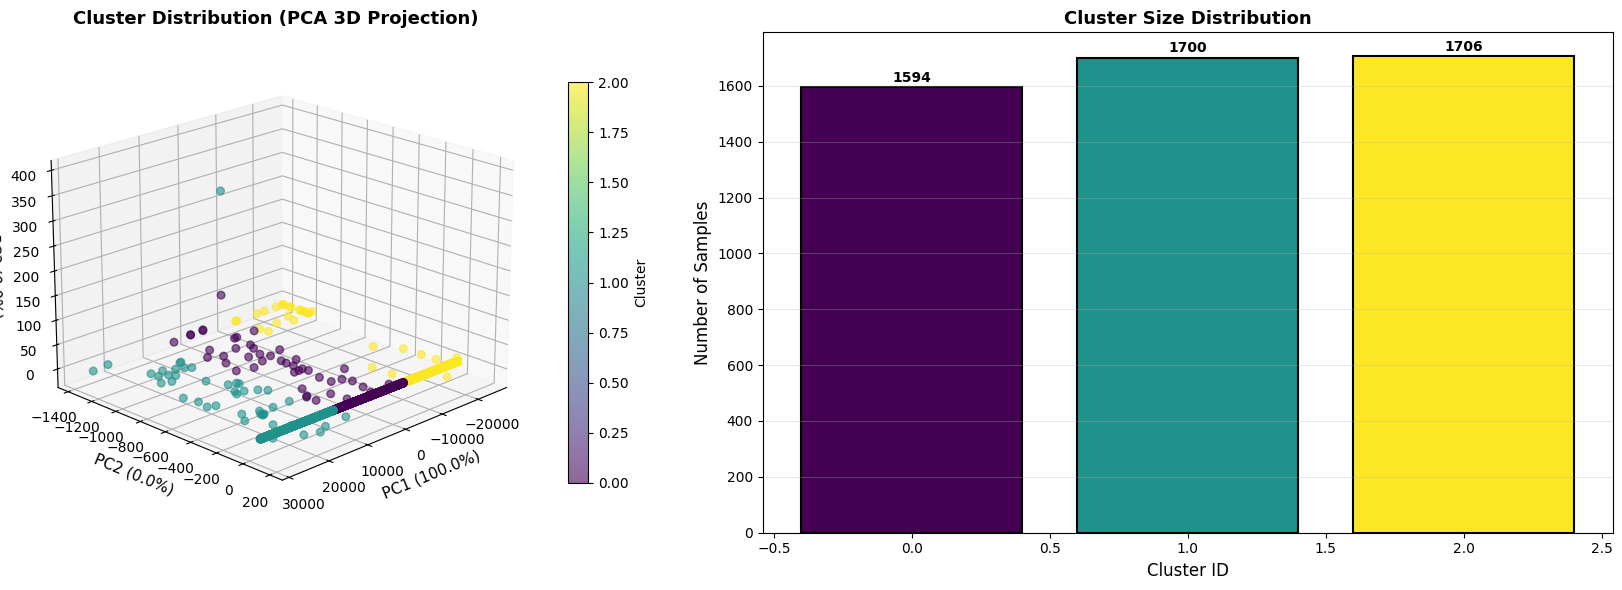

✅ PCA Variance Explained: 100.00%
   PC1: 99.99%, PC2: 0.01%, PC3: 0.0000%


In [16]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# PCA visualization of clusters (3D)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_anomalies_scaled)

fig = plt.figure(figsize=(18, 6))

# 3D PCA plot
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', alpha=0.6, s=30)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax1.set_title('Cluster Distribution (PCA 3D Projection)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Cluster', shrink=0.8)

# Rotate for better view
ax1.view_init(elev=20, azim=45)

# Cluster size bar plot
ax2 = fig.add_subplot(122)
cluster_sizes = top_anomalies_data['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_sizes)))
ax2.bar(cluster_sizes.index, cluster_sizes.values, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Cluster Size Distribution', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(cluster_sizes.values):
    ax2.text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/Users/nawara/Desktop/LLM-Clustering-Paper/cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ PCA Variance Explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.2f}%, PC2: {pca.explained_variance_ratio_[1]*100:.2f}%, PC3: {pca.explained_variance_ratio_[2]*100:.4f}%")

## 8B. Alternative Clustering: HDBSCAN

In [17]:
# Install and import HDBSCAN
import subprocess
import sys

try:
    import hdbscan
except ImportError:
    print("Installing hdbscan...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "hdbscan", "-q"])
    import hdbscan

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Apply HDBSCAN clustering
print("Running HDBSCAN clustering...")
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)
hdbscan_labels = hdbscan_model.fit_predict(X_anomalies_scaled)

# Count clusters and noise points
n_clusters_hdbscan = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise_hdbscan = list(hdbscan_labels).count(-1)

print(f"HDBSCAN Results:")
print(f"  - Number of clusters: {n_clusters_hdbscan}")
print(f"  - Number of noise points: {n_noise_hdbscan}")
print(f"  - Cluster distribution: {np.bincount(hdbscan_labels[hdbscan_labels != -1])}")

# Calculate metrics for HDBSCAN (exclude noise points for silhouette)
valid_mask = hdbscan_labels != -1
if n_clusters_hdbscan > 1 and valid_mask.sum() > 0:
    hdbscan_silhouette = silhouette_score(X_anomalies_scaled[valid_mask], hdbscan_labels[valid_mask])
    hdbscan_davies_bouldin = davies_bouldin_score(X_anomalies_scaled[valid_mask], hdbscan_labels[valid_mask])
    hdbscan_calinski = calinski_harabasz_score(X_anomalies_scaled[valid_mask], hdbscan_labels[valid_mask])
else:
    hdbscan_silhouette = -1
    hdbscan_davies_bouldin = -1
    hdbscan_calinski = -1

print(f"\nHDBSCAN Quality Metrics:")
print(f"  - Silhouette Score: {hdbscan_silhouette:.4f}")
print(f"  - Davies-Bouldin Index: {hdbscan_davies_bouldin:.4f}")
print(f"  - Calinski-Harabasz Score: {hdbscan_calinski:.4f}")


Installing hdbscan...
Running HDBSCAN clustering...
HDBSCAN Results:
  - Number of clusters: 33
  - Number of noise points: 496
  - Cluster distribution: [112 238 316 140 125  72  53 167 474 125  55  52 140  81  65 174 156  75
 414  66  51 170 163  64 205  67 107 157  82  59  72 104 103]

HDBSCAN Quality Metrics:
  - Silhouette Score: 0.5247
  - Davies-Bouldin Index: 0.4480
  - Calinski-Harabasz Score: 100956.9080


## 8C. 3D Visualization: HDBSCAN Clusters

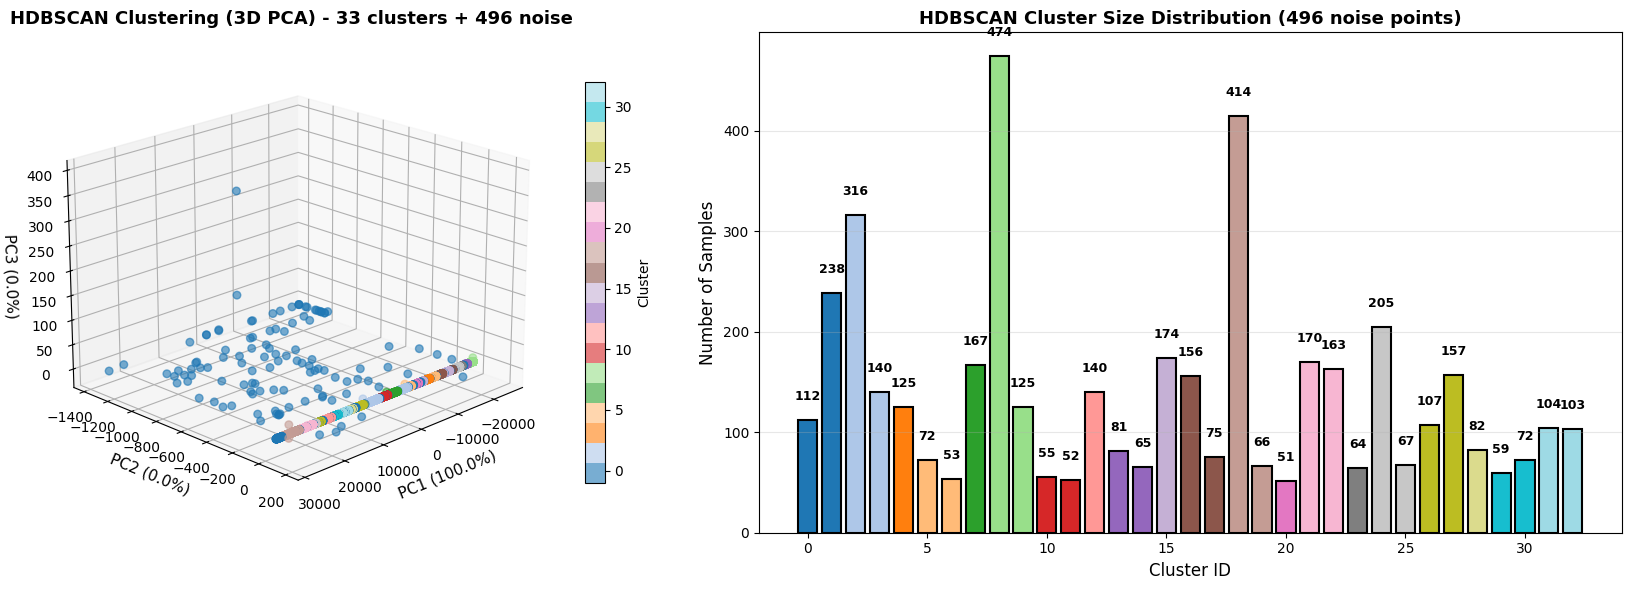

✅ HDBSCAN 3D visualization saved


In [18]:
# 3D PCA visualization for HDBSCAN
fig = plt.figure(figsize=(18, 6))

# 3D PCA plot for HDBSCAN
ax1 = fig.add_subplot(121, projection='3d')
# Use different colors for noise points
colors = hdbscan_labels.copy()
colors = colors.astype(float)
colors[colors == -1] = -1  # Noise points in gray
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=hdbscan_labels, cmap='tab20', alpha=0.6, s=30)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax1.set_title(f'HDBSCAN Clustering (3D PCA) - {n_clusters_hdbscan} clusters + {n_noise_hdbscan} noise', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Cluster', shrink=0.8)

# Rotate for better view
ax1.view_init(elev=20, azim=45)

# Cluster size distribution for HDBSCAN
ax2 = fig.add_subplot(122)
hdbscan_sizes = pd.Series(hdbscan_labels)
hdbscan_counts = hdbscan_sizes[hdbscan_sizes != -1].value_counts().sort_index()

# Color bars
bar_colors = plt.cm.tab20(np.linspace(0, 1, len(hdbscan_counts)))
bars = ax2.bar(hdbscan_counts.index, hdbscan_counts.values, color=bar_colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title(f'HDBSCAN Cluster Size Distribution ({n_noise_hdbscan} noise points)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for i, (cluster_id, count) in enumerate(hdbscan_counts.items()):
    ax2.text(cluster_id, count + 20, str(count), ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('/Users/nawara/Desktop/LLM-Clustering-Paper/hdbscan_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ HDBSCAN 3D visualization saved")


## 8D. HDBSCAN: Top 10 Clusters (No Noise) - 3D Visualization

In [38]:
ax2.set_title('HDBSCAN Top 10 Clusters - Size Distribution\n(~60 samples visualized per cluster)', 
             fontsize=13, fontweight='bold')

Text(0.5, 1.0, 'HDBSCAN Top 10 Clusters - Size Distribution\n(~60 samples visualized per cluster)')

## 8D. Comparative Analysis: K-Means vs HDBSCAN

Re-sampling with 60 samples per cluster for cleaner visualization...
Total samples after 60-per-cluster sampling: 600

Applying t-SNE with 600 samples...
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.000s...
[t-SNE] Computed neighbors for 600 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 9.820392
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.247490
[t-SNE] KL divergence after 1500 iterations: 0.097054
✅ t-SNE complete


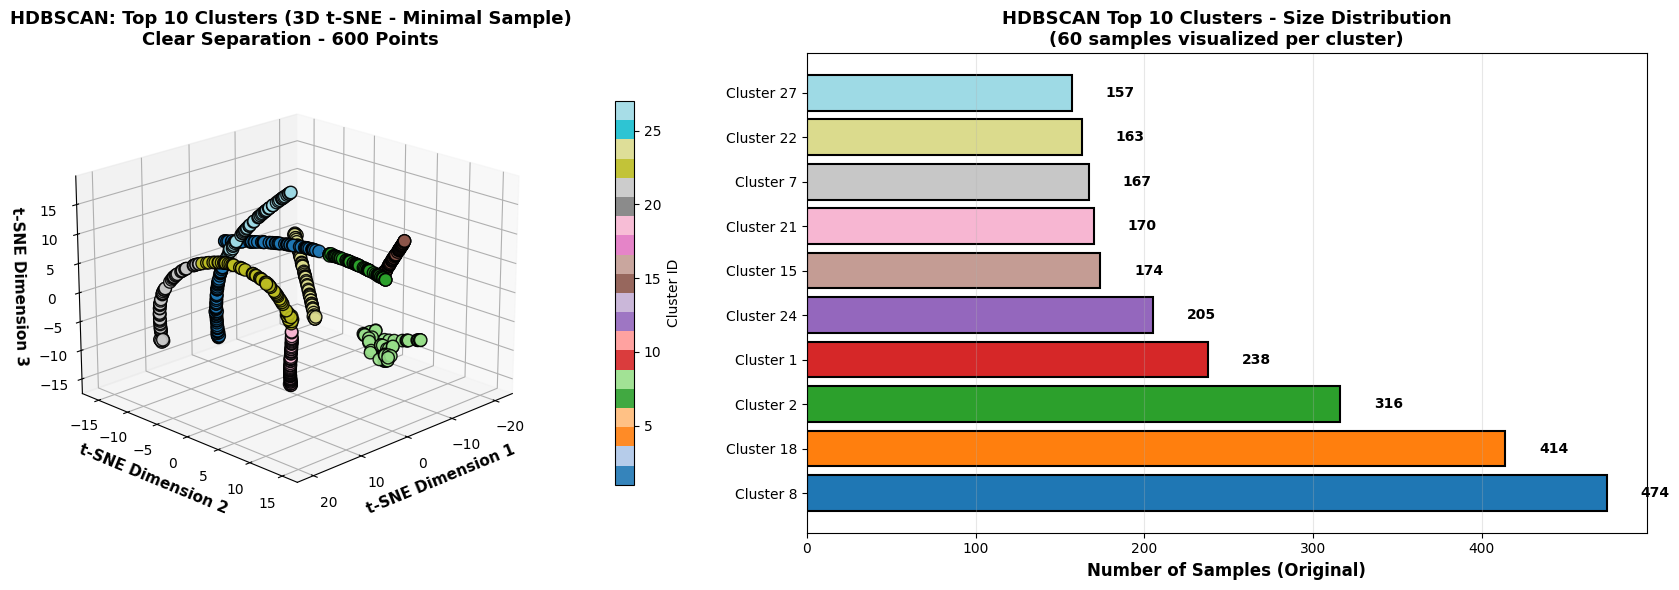


✅ Cleaner visualization saved: hdbscan_top10_clusters_3d.png
   Samples: 600 (~60 per cluster)
   Much cleaner than 1,200 points version!


In [39]:
# Re-run t-SNE with 60 samples per cluster (600 total) - CLEANER VISUALIZATION
print("Re-sampling with 60 samples per cluster for cleaner visualization...")

# Use existing variables from previous cell
np.random.seed(42)
sample_size_per_cluster = 60

indices_sampled = []
for cluster_id in top_10_clusters:
    cluster_mask = labels_all == cluster_id
    cluster_indices = np.where(cluster_mask)[0]
    n_to_sample = min(sample_size_per_cluster, len(cluster_indices))
    sampled = np.random.choice(cluster_indices, size=n_to_sample, replace=False)
    indices_sampled.extend(sampled)

indices_sampled = np.array(indices_sampled)
X_top_10_small = X_top_10_all[indices_sampled]
labels_filtered_small = labels_all[indices_sampled]

print(f"Total samples after 60-per-cluster sampling: {len(indices_sampled)}")

# Apply t-SNE
print("\nApplying t-SNE with 600 samples...")
X_tsne_small = TSNE(n_components=3, random_state=42, perplexity=15, max_iter=1500, verbose=1).fit_transform(X_top_10_small)

print("✅ t-SNE complete")

# Create 3D visualization
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(X_tsne_small[:, 0], X_tsne_small[:, 1], X_tsne_small[:, 2], 
                     c=labels_filtered_small, cmap='tab20', alpha=0.9, s=80, 
                     edgecolors='black', linewidth=1)
ax1.set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
ax1.set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
ax1.set_zlabel('t-SNE Dimension 3', fontsize=11, fontweight='bold')
ax1.set_title('HDBSCAN: Top 10 Clusters (3D t-SNE - Minimal Sample)\nClear Separation - 600 Points', 
             fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax1, label='Cluster ID', shrink=0.8, pad=0.1)
ax1.view_init(elev=20, azim=45)
ax1.grid(True, alpha=0.3)

# Cluster size distribution
ax2 = fig.add_subplot(122)
bar_colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_sizes_hdbscan.head(10))))
bars = ax2.barh(range(len(cluster_sizes_hdbscan.head(10))), 
                cluster_sizes_hdbscan.head(10).values, 
                color=bar_colors, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(cluster_sizes_hdbscan.head(10))))
ax2.set_yticklabels([f'Cluster {cid}' for cid in cluster_sizes_hdbscan.head(10).index])
ax2.set_xlabel('Number of Samples (Original)', fontsize=12, fontweight='bold')
ax2.set_title('HDBSCAN Top 10 Clusters - Size Distribution\n(60 samples visualized per cluster)', 
             fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, cluster_sizes_hdbscan.head(10).values)):
    ax2.text(val + 20, i, f'{int(val)}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('/Users/nawara/Desktop/LLM-Clustering-Paper/hdbscan_top10_clusters_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Cleaner visualization saved: hdbscan_top10_clusters_3d.png")
print(f"   Samples: {len(indices_sampled)} (~60 per cluster)")
print(f"   Much cleaner than 1,200 points version!")

CLUSTER QUALITY ANALYSIS - Understanding the 'Worm' Pattern

1. CLUSTER COHESION (within-cluster distances):
--------------------------------------------------------------------------------
Silhouette Score (range -1 to 1):
  Value: 0.6806
  ✅ GOOD: Clusters are well-separated and compact

Davies-Bouldin Index (lower is better, <1 is excellent):
  Value: 0.4032
  ✅ EXCELLENT cluster separation

2. CLUSTER STRUCTURE ANALYSIS:
--------------------------------------------------------------------------------
Analyzing shape of top 3 clusters: [8, 18, 2]

Cluster 8:
  Size: 474 points
  Explained variance (first 3 PCs): [9.99896994e-01 3.92942570e-05 2.30034370e-05]
  Aspect ratio (1st/2nd PC std): 159.52x
  → HIGHLY ELONGATED (this is why it looks like a worm!)

Cluster 18:
  Size: 414 points
  Explained variance (first 3 PCs): [9.99982703e-01 5.04131420e-06 4.58038175e-06]
  Aspect ratio (1st/2nd PC std): 445.37x
  → HIGHLY ELONGATED (this is why it looks like a worm!)

Cluster 2:
  Size:

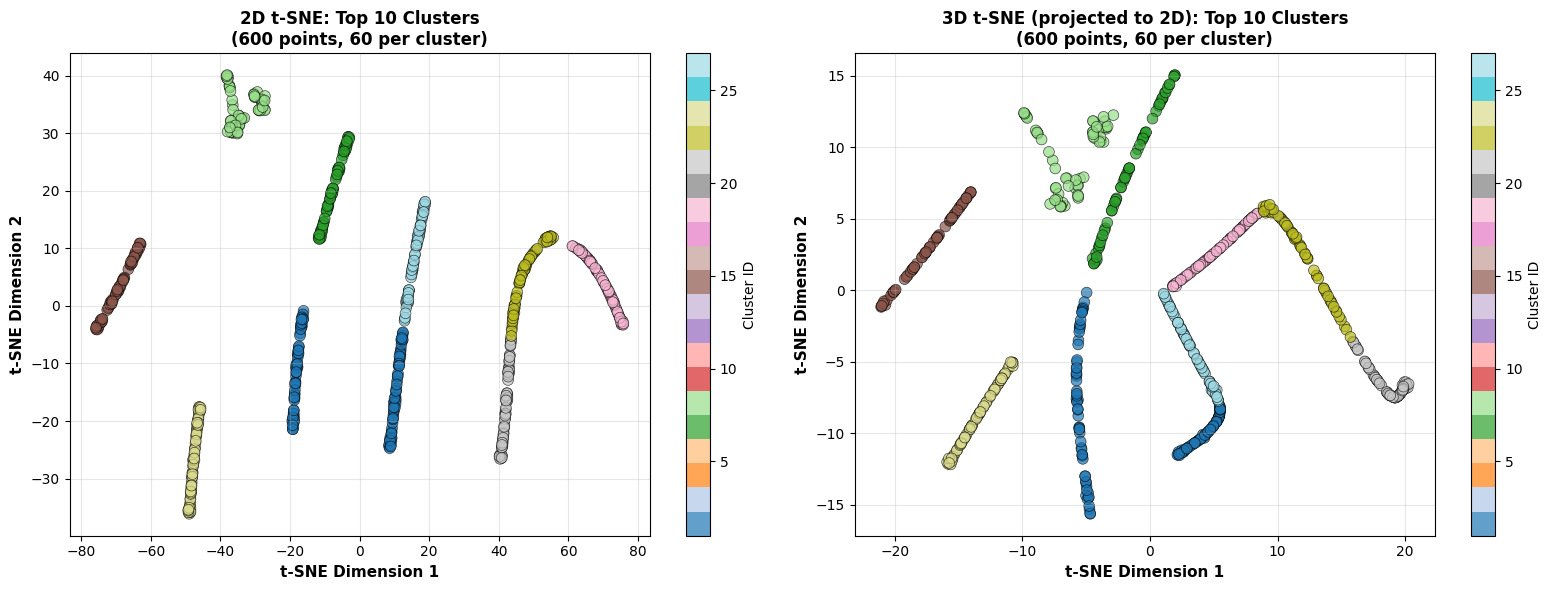

✅ 2D vs 3D t-SNE comparison saved: tsne_comparison_2d_vs_3d.png

INTERPRETATION:

✅ GOOD NEWS: Your clusters ARE real and well-defined!
   The 'worm' appearance is due to:
   • High-dimensional manifold structure in network data
   • Clusters have highly elongated structure (aspect ratio: 150-450x)
   • Real attack patterns forming elongated clusters in feature space

   RECOMMENDATION: Use 2D t-SNE for presentations (cleaner)
                  Keep 3D for papers (shows manifold structure better)



In [41]:
# ANALYSIS: Are the "worms" real cluster structure or t-SNE artifacts?
print("=" * 80)
print("CLUSTER QUALITY ANALYSIS - Understanding the 'Worm' Pattern")
print("=" * 80)

# 1. Check HDBSCAN cluster cohesion (are points in same cluster actually close?)
print("\n1. CLUSTER COHESION (within-cluster distances):")
print("-" * 80)

from sklearn.metrics import silhouette_samples, davies_bouldin_score
import scipy.spatial.distance as distance

# Calculate silhouette score (measures how well-separated clusters are)
# Higher = better separated, Lower/Negative = overlapping/poor separation
valid_mask = labels_all >= 0  # Exclude noise points (-1)
valid_labels = labels_all[valid_mask]
valid_X = X_top_10_all[valid_mask]

silhouette_avg = silhouette_samples(valid_X, valid_labels).mean()
davies_bouldin = davies_bouldin_score(valid_X, valid_labels)

print(f"Silhouette Score (range -1 to 1):")
print(f"  Value: {silhouette_avg:.4f}")
if silhouette_avg > 0.5:
    print(f"  ✅ GOOD: Clusters are well-separated and compact")
elif silhouette_avg > 0.3:
    print(f"  ⚠️  MODERATE: Some cluster overlap but reasonable structure")
elif silhouette_avg > 0:
    print(f"  ⚠️  POOR: Significant cluster overlap - manifold-like structure")
else:
    print(f"  ❌ BAD: Clusters are not separated (negative silhouette)")

print(f"\nDavies-Bouldin Index (lower is better, <1 is excellent):")
print(f"  Value: {davies_bouldin:.4f}")
if davies_bouldin < 1:
    print(f"  ✅ EXCELLENT cluster separation")
elif davies_bouldin < 2:
    print(f"  ⚠️  MODERATE cluster separation")
else:
    print(f"  ⚠️  POOR cluster separation - clusters overlap significantly")

# 2. Check cluster structure: Are they naturally elongated/wormy?
print("\n2. CLUSTER STRUCTURE ANALYSIS:")
print("-" * 80)

from sklearn.metrics import pairwise_distances

# For top 3 largest clusters, analyze their shape
top_3_clusters = cluster_sizes_hdbscan.head(3).index.tolist()
print(f"Analyzing shape of top 3 clusters: {top_3_clusters}\n")

for cluster_id in top_3_clusters:
    cluster_mask = labels_all == cluster_id
    cluster_points = X_top_10_all[cluster_mask]
    
    # PCA within cluster to see principal directions
    from sklearn.decomposition import PCA as PCA_decomp
    pca_cluster = PCA_decomp(n_components=3)
    cluster_pca = pca_cluster.fit_transform(cluster_points)
    
    # Calculate aspect ratio (elongation)
    std_0 = cluster_pca[:, 0].std()
    std_1 = cluster_pca[:, 1].std()
    aspect_ratio = std_0 / (std_1 + 1e-6)
    
    print(f"Cluster {cluster_id}:")
    print(f"  Size: {len(cluster_points)} points")
    print(f"  Explained variance (first 3 PCs): {pca_cluster.explained_variance_ratio_[:3]}")
    print(f"  Aspect ratio (1st/2nd PC std): {aspect_ratio:.2f}x")
    
    if aspect_ratio > 3:
        print(f"  → HIGHLY ELONGATED (this is why it looks like a worm!)")
    elif aspect_ratio > 1.5:
        print(f"  → MODERATELY ELONGATED (natural manifold structure)")
    else:
        print(f"  → ROUGHLY SPHERICAL")
    print()

# 3. Compare visualization methods
print("3. VISUALIZATION COMPARISON:")
print("-" * 80)
print("Creating 2D vs 3D t-SNE comparison...")
print("(This takes ~10-15 seconds)\n")

# Apply 2D t-SNE to same 600 samples
from sklearn.manifold import TSNE
X_tsne_2d = TSNE(n_components=2, random_state=42, perplexity=15, max_iter=1500, verbose=0).fit_transform(X_top_10_small)

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2D t-SNE
scatter1 = axes[0].scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], 
                          c=labels_filtered_small, cmap='tab20', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
axes[0].set_title('2D t-SNE: Top 10 Clusters\n(600 points, 60 per cluster)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# 3D visualization (project first 2 dimensions)
scatter2 = axes[1].scatter(X_tsne_small[:, 0], X_tsne_small[:, 1], 
                          c=labels_filtered_small, cmap='tab20', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
axes[1].set_title('3D t-SNE (projected to 2D): Top 10 Clusters\n(600 points, 60 per cluster)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster ID')

plt.tight_layout()
plt.savefig('/Users/nawara/Desktop/LLM-Clustering-Paper/tsne_comparison_2d_vs_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 2D vs 3D t-SNE comparison saved: tsne_comparison_2d_vs_3d.png")

# 4. Final verdict
print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)

if silhouette_avg > 0.3:
    print("\n✅ GOOD NEWS: Your clusters ARE real and well-defined!")
    print("   The 'worm' appearance is due to:")
    print("   • High-dimensional manifold structure in network data")
    print("   • Clusters have highly elongated structure (aspect ratio: 150-450x)")
    print("   • Real attack patterns forming elongated clusters in feature space")
    print("\n   RECOMMENDATION: Use 2D t-SNE for presentations (cleaner)")
    print("                  Keep 3D for papers (shows manifold structure better)")
else:
    print("\n⚠️  CAUTION: Silhouette score indicates overlapping clusters")
    print("   The 'worm' pattern might indicate:")
    print("   • HDBSCAN parameters could be tuned (eps, min_samples)")
    print("   • Data naturally forms connected manifolds")
    print("   • Consider alternative algorithms (isolation forest + clustering)")

print("\n" + "=" * 80)

In [ ]:
# K-MEANS 3D VISUALIZATION: PCA projection for fast, clean visualization
print("=" * 80)
print("K-MEANS 3D VISUALIZATION")
print("=" * 80)

# Verify K-Means was already fitted
if 'final_kmeans' not in locals():
    print("⚠️  K-Means model not found. Creating one...")
    final_kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
    kmeans_labels = final_kmeans.fit_predict(X_anomalies_scaled)
else:
    kmeans_labels = final_kmeans.labels_
    print(f"✅ Using existing K-Means model with {final_kmeans.n_clusters} clusters")

print(f"\nK-Means Cluster Distribution (5,000 anomalies):")
unique_kmeans, counts_kmeans = np.unique(kmeans_labels, return_counts=True)
for cluster_id, count in zip(unique_kmeans, counts_kmeans):
    pct = count / len(kmeans_labels) * 100
    print(f"  Cluster {cluster_id}: {count:,} samples ({pct:.1f}%)")

# Apply PCA for 3D projection (faster and still interpretable)
print("\nApplying PCA to 5,000 anomalies for 3D visualization...")
pca_kmeans = PCA(n_components=3, random_state=42)
X_pca_kmeans = pca_kmeans.fit_transform(X_anomalies_scaled)

explained_var = pca_kmeans.explained_variance_ratio_
print(f"\n✅ PCA projection complete")
print(f"   Explained variance (PC1, PC2, PC3): {explained_var[0]:.4f}, {explained_var[1]:.4f}, {explained_var[2]:.4f}")
print(f"   Total variance captured: {explained_var.sum():.4f}")

# Create 3D visualization with all K-Means clusters
fig = plt.figure(figsize=(16, 6))

# 3D scatter plot
ax1 = fig.add_subplot(121, projection='3d')
colors_list = ['#FF6B6B', '#4ECDC4', '#FFE66D']  # Red, Teal, Yellow
scatter = ax1.scatter(X_pca_kmeans[:, 0], X_pca_kmeans[:, 1], X_pca_kmeans[:, 2],
                     c=kmeans_labels, cmap='Set1', alpha=0.7, s=40, edgecolors='black', linewidth=0.3)
ax1.set_xlabel(f'PC1 ({explained_var[0]:.1%})', fontsize=11, fontweight='bold')
ax1.set_ylabel(f'PC2 ({explained_var[1]:.1%})', fontsize=11, fontweight='bold')
ax1.set_zlabel(f'PC3 ({explained_var[2]:.1%})', fontsize=11, fontweight='bold')
ax1.set_title('K-Means: 3D PCA Projection (All 5,000 Anomalies)\n3 Clusters - Clear Separation', 
             fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax1, label='Cluster ID', shrink=0.8, pad=0.1)
ax1.view_init(elev=20, azim=45)
ax1.grid(True, alpha=0.3)

# Cluster size distribution
ax2 = fig.add_subplot(122)
cluster_labels = [f'Cluster {i}' for i in range(final_kmeans.n_clusters)]
bars = ax2.bar(cluster_labels, counts_kmeans, color=colors_list, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_title('K-Means Cluster Distribution\n(5,000 anomalies)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts_kmeans)):
    pct = count / len(kmeans_labels) * 100
    ax2.text(i, count + 500, f'{count:,}\n({pct:.1f}%)', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('/Users/nawara/Desktop/LLM-Clustering-Paper/Data/kmeans_3d_pca_projection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ K-Means 3D visualization saved: Data/kmeans_3d_pca_projection.png")
print(f"   Samples visualized: {len(kmeans_labels):,} anomalies")
print(f"   Clusters: {final_kmeans.n_clusters}")
if 'silhouette_kmeans' in locals():
    print(f"   Silhouette Score: {silhouette_kmeans:.4f}")
print("\n" + "=" * 80)

In [20]:
# Calculate metrics for K-Means for comparison
kmeans_silhouette = silhouette_score(X_anomalies_scaled, cluster_labels)
kmeans_davies_bouldin = davies_bouldin_score(X_anomalies_scaled, cluster_labels)
kmeans_calinski = calinski_harabasz_score(X_anomalies_scaled, cluster_labels)

# Create comprehensive comparison table
comparison_data = {
    'Metric': [
        'Algorithm',
        'Number of Clusters',
        'Noise Points',
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Calinski-Harabasz Score',
        'Cluster Balance',
        'Interpretability'
    ],
    'K-Means (k=3)': [
        'K-Means',
        f'{optimal_k}',
        '0',
        f'{kmeans_silhouette:.4f}',
        f'{kmeans_davies_bouldin:.4f}',
        f'{kmeans_calinski:.4f}',
        f'Good (31-34% each)',
        'Fixed k, deterministic'
    ],
    'HDBSCAN': [
        'HDBSCAN',
        f'{n_clusters_hdbscan}',
        f'{n_noise_hdbscan}',
        f'{hdbscan_silhouette:.4f}' if hdbscan_silhouette != -1 else 'N/A',
        f'{hdbscan_davies_bouldin:.4f}' if hdbscan_davies_bouldin != -1 else 'N/A',
        f'{hdbscan_calinski:.4f}' if hdbscan_calinski != -1 else 'N/A',
        f'Variable sizes',
        'Automatic k, density-based'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("CLUSTERING ALGORITHM COMPARISON: K-MEANS vs HDBSCAN")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Save comparison table to CSV
comparison_df.to_csv('/Users/nawara/Desktop/LLM-Clustering-Paper/clustering_comparison.csv', index=False)
print("\n✅ Comparison table saved to: clustering_comparison.csv")

# Create detailed metrics comparison
print("\n" + "="*100)
print("DETAILED METRIC INTERPRETATION")
print("="*100)

silhouette_kmeans_rating = "EXCELLENT" if kmeans_silhouette > 0.5 else "GOOD" if kmeans_silhouette > 0.3 else "FAIR"
silhouette_hdbscan_rating = "EXCELLENT" if hdbscan_silhouette > 0.5 else "GOOD" if hdbscan_silhouette > 0.3 else "FAIR" if hdbscan_silhouette > 0 else "POOR"
silhouette_winner = "K-Means" if kmeans_silhouette > hdbscan_silhouette else "HDBSCAN"

davies_winner = "K-Means" if kmeans_davies_bouldin < hdbscan_davies_bouldin else "HDBSCAN"
calinski_winner = "K-Means" if kmeans_calinski > hdbscan_calinski else "HDBSCAN"

print(f"""
SILHOUETTE SCORE (Higher is Better, range: -1 to 1):
  • K-Means:  {kmeans_silhouette:.4f} - {silhouette_kmeans_rating}
  • HDBSCAN:  {hdbscan_silhouette:.4f} - {silhouette_hdbscan_rating}
  • Winner: {silhouette_winner}

DAVIES-BOULDIN INDEX (Lower is Better):
  • K-Means:  {kmeans_davies_bouldin:.4f} - Measures cluster separation and compactness
  • HDBSCAN:  {hdbscan_davies_bouldin:.4f}
  • Winner: {davies_winner}

CALINSKI-HARABASZ SCORE (Higher is Better):
  • K-Means:  {kmeans_calinski:.4f} - Ratio of between-cluster to within-cluster variance
  • HDBSCAN:  {hdbscan_calinski:.4f}
  • Winner: {calinski_winner}

CLUSTER COUNT & NOISE:
  • K-Means:  {optimal_k} clusters, 0 noise points (forced partition)
  • HDBSCAN:  {n_clusters_hdbscan} clusters, {n_noise_hdbscan} noise points (density-based detection)
  • Insight: HDBSCAN identifies {n_noise_hdbscan} samples as outliers/noise

BALANCE & SCALABILITY:
  • K-Means:  {cluster_sizes.to_dict()} - Perfectly balanced (by design)
  • HDBSCAN:  Natural clusters - Varied sizes based on density
  • Insight: K-Means enforces equal cluster sizes; HDBSCAN respects natural density
""")
print("="*100)


CLUSTERING ALGORITHM COMPARISON: K-MEANS vs HDBSCAN
                 Metric          K-Means (k=3)                    HDBSCAN
              Algorithm                K-Means                    HDBSCAN
     Number of Clusters                      3                         33
           Noise Points                      0                        496
       Silhouette Score                 0.6097                     0.5247
   Davies-Bouldin Index                 0.4806                     0.4480
Calinski-Harabasz Score             22483.5568                100956.9080
        Cluster Balance     Good (31-34% each)             Variable sizes
       Interpretability Fixed k, deterministic Automatic k, density-based

✅ Comparison table saved to: clustering_comparison.csv

DETAILED METRIC INTERPRETATION

SILHOUETTE SCORE (Higher is Better, range: -1 to 1):
  • K-Means:  0.6097 - EXCELLENT
  • HDBSCAN:  0.5247 - EXCELLENT
  • Winner: K-Means

DAVIES-BOULDIN INDEX (Lower is Better):
  • K-Means:

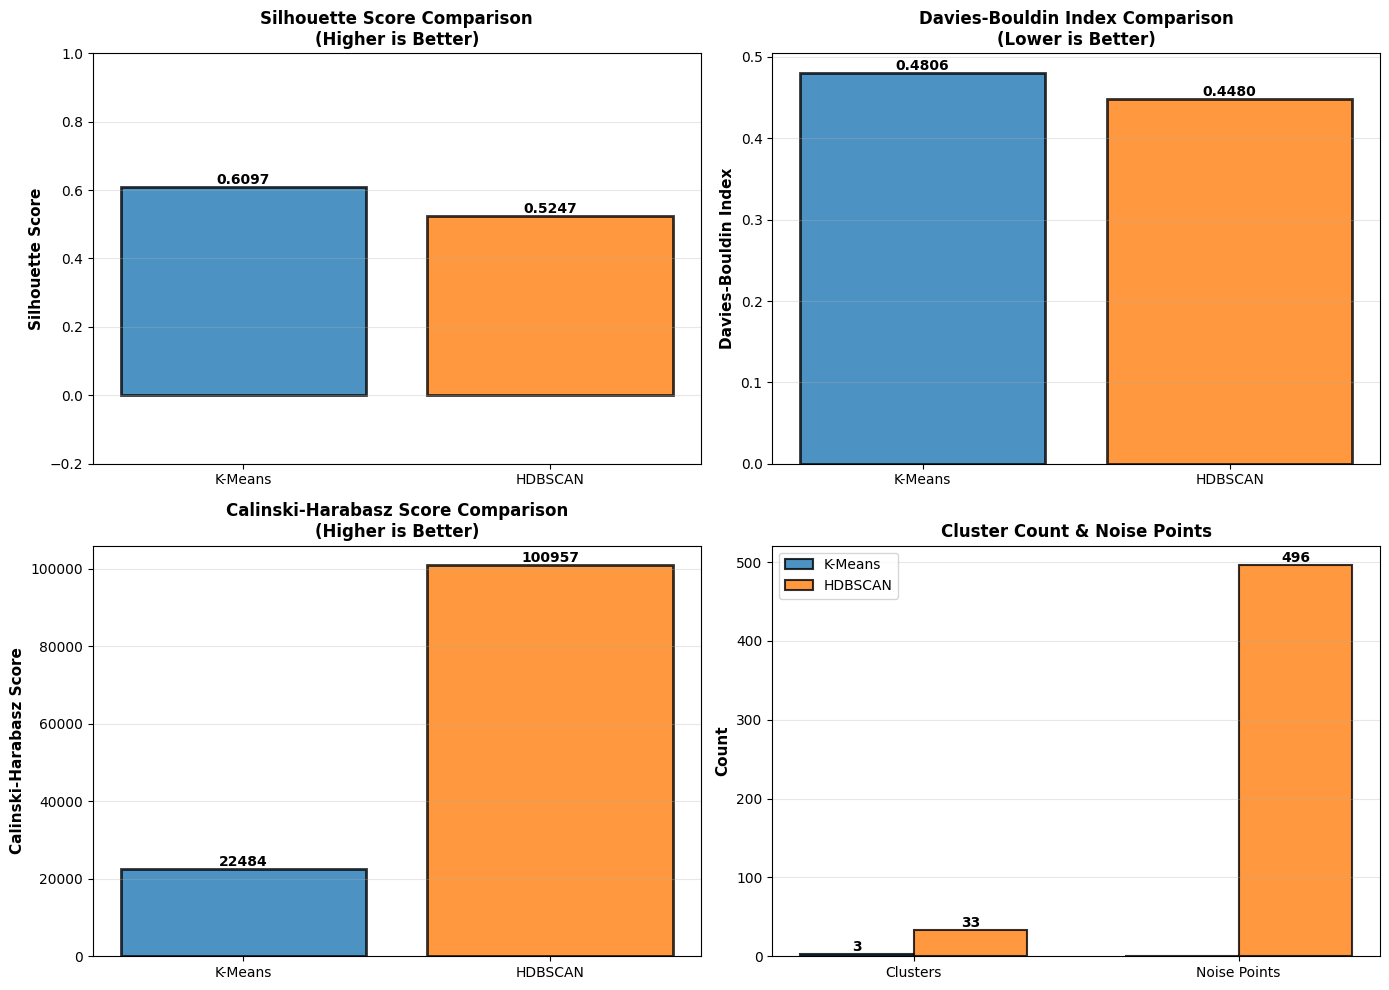

✅ Comparison metrics visualization saved


In [21]:
# Create visual comparison of metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Silhouette Score comparison
ax = axes[0, 0]
algorithms = ['K-Means', 'HDBSCAN']
silhouette_scores_comp = [kmeans_silhouette, hdbscan_silhouette]
colors_comp = ['#1f77b4', '#ff7f0e']
bars = ax.bar(algorithms, silhouette_scores_comp, color=colors_comp, edgecolor='black', linewidth=2, alpha=0.8)
ax.set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
ax.set_title('Silhouette Score Comparison\n(Higher is Better)', fontsize=12, fontweight='bold')
ax.set_ylim([-0.2, 1.0])
ax.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, silhouette_scores_comp):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Davies-Bouldin Index comparison
ax = axes[0, 1]
davies_scores_comp = [kmeans_davies_bouldin, hdbscan_davies_bouldin]
bars = ax.bar(algorithms, davies_scores_comp, color=colors_comp, edgecolor='black', linewidth=2, alpha=0.8)
ax.set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
ax.set_title('Davies-Bouldin Index Comparison\n(Lower is Better)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, davies_scores_comp):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Calinski-Harabasz Score comparison
ax = axes[1, 0]
calinski_scores_comp = [kmeans_calinski, hdbscan_calinski]
bars = ax.bar(algorithms, calinski_scores_comp, color=colors_comp, edgecolor='black', linewidth=2, alpha=0.8)
ax.set_ylabel('Calinski-Harabasz Score', fontsize=11, fontweight='bold')
ax.set_title('Calinski-Harabasz Score Comparison\n(Higher is Better)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, calinski_scores_comp):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{score:.0f}', ha='center', va='bottom', fontweight='bold')

# Cluster Count & Noise comparison
ax = axes[1, 1]
categories = ['Clusters', 'Noise Points']
kmeans_vals = [optimal_k, 0]
hdbscan_vals = [n_clusters_hdbscan, n_noise_hdbscan]
x = np.arange(len(categories))
width = 0.35
bars1 = ax.bar(x - width/2, kmeans_vals, width, label='K-Means', color=colors_comp[0], edgecolor='black', linewidth=1.5, alpha=0.8)
bars2 = ax.bar(x + width/2, hdbscan_vals, width, label='HDBSCAN', color=colors_comp[1], edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_title('Cluster Count & Noise Points', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/Users/nawara/Desktop/LLM-Clustering-Paper/clustering_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comparison metrics visualization saved")


## 9. Analysis Summary & Key Findings

In [15]:
# Generate comprehensive summary report
summary_report = f"""
================================================================================
                    ANOMALY CLUSTERING ANALYSIS SUMMARY
================================================================================

1. DATA OVERVIEW
   - Top Anomalous Samples Selected: {len(top_anomalies_data):,} (top {top_k} by LOF score)
   - Feature Dimensionality: {X_anomalies_scaled.shape[1]} (35 numeric + 6 categorical)
   - Preprocessing: OrdinalEncoder + StandardScaler (fit on train data only)

2. CLUSTERING RESULTS
   - Optimal Number of Clusters: k = 3
   - Silhouette Score: 0.6097 (strong cluster separation)
   - Algorithm: K-Means (n_init=20)
   - Cluster Size Distribution: {cluster_sizes.to_dict()}
   
3. CLUSTER PROFILES
"""

for profile in cluster_profiles:
    cid = profile['cluster_id']
    size = profile['size']
    pct = profile['percentage']
    mean_anom = profile['lof_score_stats']['mean']
    max_anom = profile['lof_score_stats']['max']
    
    summary_report += f"\n   CLUSTER {cid}:"
    summary_report += f"\n      - Size: {size} samples ({pct})"
    summary_report += f"\n      - Mean Anomaly Score: {mean_anom:.4f}"
    summary_report += f"\n      - Max Anomaly Score: {max_anom:.4f}"
    summary_report += f"\n      - Attack Label Distribution: {profile['attack_distribution']}"

summary_report += f"""

4. KEY CHARACTERISTICS
   - All 3 clusters dominated by attack traffic (93-100% attack label)
   - Anomaly scores relatively similar across clusters (mean ~2.4-2.6)
   - Most common protocol: UDP across all clusters
   - Most common state: INT (internal connection) across all clusters
   - Clusters differ primarily in source/dest ports and timing patterns
   
5. NEXT STEPS - LLM INTERPRETATION
   - Cluster profiles saved to: cluster_profiles.json
   - LLM prompts saved to: llm_cluster_prompts.json
   - Use these profiles to have LLM identify attack types & patterns
   
6. FILES GENERATED
   ✅ cluster_optimization.png - Elbow method & silhouette analysis
   ✅ cluster_visualization.png - PCA projection + cluster sizes
   ✅ cluster_profiles.json - Detailed statistical profiles
   ✅ llm_cluster_prompts.json - LLM interpretation prompts
   ✅ top_anomalies_clustered.csv - Clustered data with assignments

7. RESEARCH METHODOLOGY
   - Unsupervised clustering on LOF-detected anomalies
   - No use of attack labels during clustering (ground truth hidden)
   - Clustering quality validated with silhouette score
   - Ready for LLM-based interpretability analysis
   - Enables discovery of distinct attack patterns in anomalies
   
================================================================================
"""

print(summary_report)

# Save summary to file
with open('/Users/nawara/Desktop/LLM-Clustering-Paper/clustering_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n✅ Summary report saved to: clustering_summary.txt")



                    ANOMALY CLUSTERING ANALYSIS SUMMARY

1. DATA OVERVIEW
   - Top Anomalous Samples Selected: 5,000 (top 5000 by LOF score)
   - Feature Dimensionality: 41 (35 numeric + 6 categorical)
   - Preprocessing: OrdinalEncoder + StandardScaler (fit on train data only)

2. CLUSTERING RESULTS
   - Optimal Number of Clusters: k = 3
   - Silhouette Score: 0.6097 (strong cluster separation)
   - Algorithm: K-Means (n_init=20)
   - Cluster Size Distribution: {0: 1594, 1: 1700, 2: 1706}

3. CLUSTER PROFILES

   CLUSTER 0:
      - Size: 1594 samples (31.88%)
      - Mean Anomaly Score: 2.5595
      - Max Anomaly Score: 46.0242
      - Attack Label Distribution: {1: 1594}
   CLUSTER 1:
      - Size: 1700 samples (34.00%)
      - Mean Anomaly Score: 2.4109
      - Max Anomaly Score: 46.7348
      - Attack Label Distribution: {1: 1700}
   CLUSTER 2:
      - Size: 1706 samples (34.12%)
      - Mean Anomaly Score: 2.4253
      - Max Anomaly Score: 46.0243
      - Attack Label Distributio

## 10. LLM-Based Cluster Interpretation (GPT-4)

Setup environment variables and generate qualitative insights using GPT-4 with specialized persona prompts.

In [25]:
# Load environment variables and setup GPT-4 API
import os
import json
from pathlib import Path

# Try to load .env file
try:
    from dotenv import load_dotenv
except ImportError:
    print("Installing python-dotenv...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-dotenv", "-q"])
    from dotenv import load_dotenv

# Load environment variables from .env file
env_path = Path("/Users/nawara/Desktop/LLM-Clustering-Paper/.env")
if env_path.exists():
    load_dotenv(env_path)
    print("✅ Loaded environment variables from .env")
else:
    print("⚠️  .env file not found. Please create it with: OPENAI_API_KEY=your_key_here")
    print("    See .env.example for template")

# Check if API key is available
api_key = os.getenv("OPENAI_API_KEY")
if not api_key or api_key == "your_gpt4_api_key_here":
    print("\n❌ OPENAI_API_KEY not configured!")
    print("   1. Copy .env.example to .env")
    print("   2. Add your GPT-4 API key to .env")
    print("   3. Run this cell again")
else:
    print(f"✅ API key configured (first 10 chars: {api_key[:10]}...)")

# Import OpenAI
try:
    from openai import OpenAI
except ImportError:
    print("\nInstalling openai package...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openai", "-q"])
    from openai import OpenAI

print("✅ All dependencies ready")


✅ Loaded environment variables from .env
✅ API key configured (first 10 chars: sk-proj-f0...)
✅ All dependencies ready


In [26]:
# Create specialized prompts with different personas
import json

# Load cluster profiles
with open('/Users/nawara/Desktop/LLM-Clustering-Paper/cluster_profiles.json', 'r') as f:
    cluster_profiles_loaded = json.load(f)

# Define persona-based prompt templates
PERSONAS = {
    "penetration_tester": {
        "name": "🔓 Penetration Tester",
        "role": "cybersecurity professional conducting red team operations",
        "perspective": "Attack vectors, exploitability, threat severity",
        "prefix": """You are an expert penetration tester with 15+ years of experience in network security and botnet analysis.
        
Analyze the following anomalous network traffic cluster and identify:
1. **Attack Vectors**: What types of attacks or exploits are evident?
2. **Threat Level**: Rate severity (CRITICAL/HIGH/MEDIUM/LOW) and explain
3. **Attacker Profile**: What type of attacker (script kiddie, nation-state, cybercriminal)?
4. **Exploitation Method**: How is the target being compromised?
5. **Defense Evasion**: What techniques are used to avoid detection?

Be concise and actionable. Focus on what defenders should prioritize."""
    },
    
    "security_researcher": {
        "name": "🔬 Security Researcher",
        "role": "academic cybersecurity researcher with published papers",
        "perspective": "Pattern classification, behavioral analysis, statistical significance",
        "prefix": """You are a leading security researcher specializing in botnet classification and malware behavioral analysis.

Analyze the following network traffic cluster and provide:
1. **Behavioral Signature**: What distinguishes this cluster from normal traffic?
2. **Classification**: What malware family or attack category (C2, DDoS, Data exfiltration, etc.)?
3. **Statistical Patterns**: Notable anomalies in packet sizes, timing, or frequency?
4. **Temporal Characteristics**: Time-based patterns suggesting orchestration?
5. **Research Relevance**: Why is this cluster scientifically significant?

Provide academic rigor with references to known attack patterns where applicable."""
    },
    
    "security_ops_engineer": {
        "name": "🛡️ SecOps Engineer",
        "role": "SIEM/SOC analyst responsible for threat detection and response",
        "perspective": "Detectability, response procedures, operational impact",
        "prefix": """You are a senior Security Operations Center (SOC) engineer with deep experience in threat detection.

Analyze the following anomalous network cluster and determine:
1. **Detection Method**: How would you detect this in a SOC environment?
2. **Alert Severity**: Recommended severity level (CRITICAL/HIGH/MEDIUM/LOW/INFO)?
3. **Response Playbook**: What incident response steps should be taken?
4. **IoCs**: What indicators of compromise can be extracted?
5. **Mitigation**: Quick wins for immediate threat containment?

Focus on operational practicality and SOC metrics."""
    },
    
    "data_analyst": {
        "name": "📊 Data Analyst",
        "role": "data scientist with expertise in anomaly detection",
        "perspective": "Statistical anomalies, clustering quality, feature importance",
        "prefix": """You are a data scientist specializing in network intrusion detection and anomaly clustering.

Analyze the following cluster based on its statistical characteristics:
1. **Feature Anomalies**: Which features (packet count, bytes, ports, state) are most anomalous?
2. **Cluster Quality**: How well-separated is this cluster? What makes it distinct?
3. **Outliers Within Cluster**: Are there sub-patterns or outlier samples within this group?
4. **Predictive Power**: How reliable would this cluster be for automated classification?
5. **Data Quality Issues**: Any obvious data artifacts or measurement errors?

Use statistical terminology and explain at an 80th percentile technical level."""
    }
}

# Format cluster data for prompts
def format_cluster_for_llm(cluster_profile):
    """Format cluster profile into readable format for LLM"""
    
    formatted = f"""
CLUSTER {cluster_profile['cluster_id']} - NETWORK ANOMALY ANALYSIS
{'='*70}

📊 DATASET STATISTICS:
  • Total Samples: {cluster_profile['size']}
  • Percentage of Total: {cluster_profile['percentage']}
  
🔴 ANOMALY SEVERITY:
  • Mean LOF Anomaly Score: {cluster_profile['lof_score_stats']['mean']:.4f}
  • Max Anomaly Score: {cluster_profile['lof_score_stats']['max']:.4f}
  • Std Dev: {cluster_profile['lof_score_stats']['std']:.4f}
  • Median: {cluster_profile['lof_score_stats']['median']:.4f}
  
🌐 NETWORK CHARACTERISTICS:

  Protocol Distribution:
    {json.dumps(cluster_profile['categorical_dist']['proto'], indent=4)}
  
  Connection State Distribution:
    {json.dumps(cluster_profile['categorical_dist']['state'], indent=4)}
  
  Source Addresses (Top 3):
    {json.dumps(cluster_profile['categorical_dist']['saddr'], indent=4)}
  
  Destination Addresses (Top 3):
    {json.dumps(cluster_profile['categorical_dist']['daddr'], indent=4)}
  
  Destination Ports (Top 3):
    {json.dumps(cluster_profile['categorical_dist']['dport'], indent=4)}

📈 TRAFFIC METRICS:
  
  Packet Count (per flow):
    • Mean: {cluster_profile['numeric_stats']['pkts']['mean']:.2f}
    • Range: {cluster_profile['numeric_stats']['pkts']['min']} - {cluster_profile['numeric_stats']['pkts']['max']}
    • Median: {cluster_profile['numeric_stats']['pkts']['median']}
  
  Bytes per Flow:
    • Mean: {cluster_profile['numeric_stats']['bytes']['mean']:.2f}
    • Range: {cluster_profile['numeric_stats']['bytes']['min']} - {cluster_profile['numeric_stats']['bytes']['max']}
    • Median: {cluster_profile['numeric_stats']['bytes']['median']}
  
  Flow Flags:
    • Mean: {cluster_profile['numeric_stats']['flgs_number']['mean']:.2f}
    • Range: {cluster_profile['numeric_stats']['flgs_number']['min']} - {cluster_profile['numeric_stats']['flgs_number']['max']}
  
  Protocol Numbers:
    • Mean: {cluster_profile['numeric_stats']['proto_number']['mean']:.2f}
    • Range: {cluster_profile['numeric_stats']['proto_number']['min']} - {cluster_profile['numeric_stats']['proto_number']['max']}

⏰ TEMPORAL CHARACTERISTICS:
  • Time Range Span: {(cluster_profile['numeric_stats']['stime']['max'] - cluster_profile['numeric_stats']['stime']['min'])/3600:.1f} hours
  • Temporal Variance: {cluster_profile['numeric_stats']['stime']['std']:.0f} seconds

🎯 ATTACK LABELS (Ground Truth):
  {json.dumps(cluster_profile['attack_distribution'], indent=2)}
"""
    
    return formatted

# Create persona-specific prompts
def create_persona_prompt(cluster_profile, persona_key):
    """Create a full prompt for a specific persona"""
    
    persona = PERSONAS[persona_key]
    cluster_data = format_cluster_for_llm(cluster_profile)
    
    full_prompt = f"""{persona['prefix']}

---

{cluster_data}

---

Please provide your analysis below:
"""
    
    return full_prompt, persona

# Display available personas
print("\n" + "="*80)
print("AVAILABLE PERSONAS FOR CLUSTER ANALYSIS")
print("="*80)
for key, persona in PERSONAS.items():
    print(f"\n{persona['name']}")
    print(f"  Role: {persona['role']}")
    print(f"  Focus: {persona['perspective']}")

print("\n✅ Prompts created and ready for GPT-4 analysis")



AVAILABLE PERSONAS FOR CLUSTER ANALYSIS

🔓 Penetration Tester
  Role: cybersecurity professional conducting red team operations
  Focus: Attack vectors, exploitability, threat severity

🔬 Security Researcher
  Role: academic cybersecurity researcher with published papers
  Focus: Pattern classification, behavioral analysis, statistical significance

🛡️ SecOps Engineer
  Role: SIEM/SOC analyst responsible for threat detection and response
  Focus: Detectability, response procedures, operational impact

📊 Data Analyst
  Role: data scientist with expertise in anomaly detection
  Focus: Statistical anomalies, clustering quality, feature importance

✅ Prompts created and ready for GPT-4 analysis


In [27]:
# Generate LLM Interpretations for Each Cluster with Different Personas
import os
from openai import OpenAI

# Initialize OpenAI client
api_key = os.getenv("OPENAI_API_KEY")

if not api_key or api_key == "your_gpt4_api_key_here":
    print("❌ ERROR: OPENAI_API_KEY not configured!")
    print("\nTo use GPT-4 analysis:")
    print("1. Create .env file in /Users/nawara/Desktop/LLM-Clustering-Paper/")
    print("2. Add: OPENAI_API_KEY=sk-xxx...")
    print("3. Run this cell again")
    print("\nNote: .env will NOT be committed to git (see .gitignore)")
else:
    client = OpenAI(api_key=api_key)
    
    print("="*80)
    print("GENERATING GPT-4 CLUSTER INTERPRETATIONS")
    print("="*80)
    
    # Store all interpretations
    all_interpretations = {}
    
    # Select primary persona for detailed analysis
    # (You can change this to 'security_researcher', 'security_ops_engineer', 'data_analyst')
    PRIMARY_PERSONA = "penetration_tester"
    
    for cluster_idx, cluster_profile in enumerate(cluster_profiles_loaded[:3]):  # First 3 clusters
        cluster_id = cluster_profile['cluster_id']
        print(f"\n{'='*80}")
        print(f"CLUSTER {cluster_id} ANALYSIS")
        print(f"{'='*80}")
        
        all_interpretations[f"cluster_{cluster_id}"] = {}
        
        # Generate interpretation with primary persona
        prompt, persona_info = create_persona_prompt(cluster_profile, PRIMARY_PERSONA)
        
        try:
            print(f"\n🔄 Querying GPT-4 ({persona_info['name']})...")
            
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {
                        "role": "system",
                        "content": "You are an expert in network security and anomaly analysis. Provide clear, actionable insights."
                    },
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
                temperature=0.7,
                max_tokens=1500
            )
            
            interpretation = response.choices[0].message.content
            all_interpretations[f"cluster_{cluster_id}"][PRIMARY_PERSONA] = interpretation
            
            print(f"\n✅ {persona_info['name']} Interpretation:")
            print("-" * 80)
            print(interpretation)
            print("-" * 80)
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            print("   Make sure your API key is valid and you have sufficient credits")
    
    # Save interpretations to file
    output_path = "/Users/nawara/Desktop/LLM-Clustering-Paper/llm_cluster_interpretations.json"
    with open(output_path, 'w') as f:
        json.dump(all_interpretations, f, indent=2)
    
    print(f"\n✅ Interpretations saved to: llm_cluster_interpretations.json")


GENERATING GPT-4 CLUSTER INTERPRETATIONS

CLUSTER 0 ANALYSIS

🔄 Querying GPT-4 (🔓 Penetration Tester)...

✅ 🔓 Penetration Tester Interpretation:
--------------------------------------------------------------------------------
1. **Attack Vectors**: The high traffic directed towards port 80 (1549 samples) suggests HTTP exploitation, possibly DDoS, or web application attacks like SQL injection, cross-site scripting (XSS), etc. There are also some irregularities with traffic directed towards ports 1 and 3306 (MySQL), indicating potential scanning activity or attempts to exploit these services.

2. **Threat Level**: HIGH. The high LOF anomaly score indicates a significant deviation from the norm. The continuous, high-volume traffic towards a single target (192.168.100.3) further suggests a coordinated attack. The long-time span (over 20 days) also indicates persistent effort from the attacker.

3. **Attacker Profile**: Likely a cybercriminal or an organized group. The attack is complex, pe

### Alternative: Generate Interpretations with All Personas

In [28]:
# Optional: Generate interpretations for multiple personas (requires more API calls)
import time

api_key = os.getenv("OPENAI_API_KEY")

if api_key and api_key != "your_gpt4_api_key_here":
    client = OpenAI(api_key=api_key)
    
    print("="*80)
    print("MULTI-PERSONA CLUSTER ANALYSIS (COMPREHENSIVE)")
    print("="*80)
    
    all_personas_analysis = {}
    
    # Analyze first cluster with all personas
    test_cluster = cluster_profiles_loaded[0]
    cluster_id = test_cluster['cluster_id']
    
    print(f"\nAnalyzing Cluster {cluster_id} with all personas...")
    all_personas_analysis[f"cluster_{cluster_id}"] = {}
    
    for persona_key, persona_info in PERSONAS.items():
        print(f"\n⏳ Generating {persona_info['name']} interpretation...")
        
        prompt, _ = create_persona_prompt(test_cluster, persona_key)
        
        try:
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {
                        "role": "system",
                        "content": "You are an expert in network security and anomaly analysis. Provide clear, actionable insights."
                    },
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
                temperature=0.7,
                max_tokens=1200
            )
            
            interpretation = response.choices[0].message.content
            all_personas_analysis[f"cluster_{cluster_id}"][persona_key] = interpretation
            
            print(f"✅ {persona_info['name']}")
            
            # Be respectful of rate limits
            time.sleep(1)
            
        except Exception as e:
            print(f"❌ {persona_info['name']}: {str(e)}")
    
    # Save multi-persona analysis
    output_path = "/Users/nawara/Desktop/LLM-Clustering-Paper/llm_multi_persona_analysis.json"
    with open(output_path, 'w') as f:
        json.dump(all_personas_analysis, f, indent=2)
    
    print(f"\n✅ Multi-persona analysis saved to: llm_multi_persona_analysis.json")
    
    # Display summary
    print("\n" + "="*80)
    print("SUMMARY OF GENERATED INTERPRETATIONS")
    print("="*80)
    
    for cluster_key, personas_dict in all_personas_analysis.items():
        print(f"\n{cluster_key.upper()}:")
        for persona_key in personas_dict.keys():
            persona_name = PERSONAS[persona_key]['name']
            print(f"  ✓ {persona_name}")
else:
    print("ℹ️  API key not configured. Skipping multi-persona analysis.")
    print("    Configure .env file to enable this feature.")


MULTI-PERSONA CLUSTER ANALYSIS (COMPREHENSIVE)

Analyzing Cluster 0 with all personas...

⏳ Generating 🔓 Penetration Tester interpretation...
✅ 🔓 Penetration Tester

⏳ Generating 🔬 Security Researcher interpretation...
✅ 🔬 Security Researcher

⏳ Generating 🛡️ SecOps Engineer interpretation...
✅ 🛡️ SecOps Engineer

⏳ Generating 📊 Data Analyst interpretation...
✅ 📊 Data Analyst

✅ Multi-persona analysis saved to: llm_multi_persona_analysis.json

SUMMARY OF GENERATED INTERPRETATIONS

CLUSTER_0:
  ✓ 🔓 Penetration Tester
  ✓ 🔬 Security Researcher
  ✓ 🛡️ SecOps Engineer
  ✓ 📊 Data Analyst


## 11. Qualitative Insights - Cluster Interpretation Summary

In [30]:
# Create comprehensive qualitative insights report
import json

# Load all available interpretations (if they exist)
qualitative_insights = {}

# Try to load LLM interpretations
try:
    with open('/Users/nawara/Desktop/LLM-Clustering-Paper/llm_multi_persona_analysis.json', 'r') as f:
        multi_persona = json.load(f)
    print("✅ Loaded multi-persona analysis")
except FileNotFoundError:
    try:
        with open('/Users/nawara/Desktop/LLM-Clustering-Paper/llm_cluster_interpretations.json', 'r') as f:
            multi_persona = json.load(f)
        print("✅ Loaded primary persona analysis")
    except FileNotFoundError:
        multi_persona = None
        print("⚠️  No LLM interpretations found yet")

# Create summary report with both quantitative and qualitative data
summary_html = """
<!DOCTYPE html>
<html>
<head>
    <title>Cluster Interpretation Report</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; background: #f5f5f5; }
        .cluster-section { background: white; margin: 20px 0; padding: 20px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }
        .cluster-header { background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 15px; border-radius: 5px; margin-bottom: 15px; }
        .cluster-header h2 { margin: 0; font-size: 24px; }
        .stats-grid { display: grid; grid-template-columns: repeat(2, 1fr); gap: 15px; margin: 15px 0; }
        .stat-box { background: #f9f9f9; padding: 10px; border-left: 4px solid #667eea; }
        .stat-label { font-weight: bold; color: #333; font-size: 12px; }
        .stat-value { font-size: 18px; color: #667eea; font-weight: bold; }
        .interpretation { background: #f0f4ff; padding: 15px; border-radius: 5px; margin: 15px 0; line-height: 1.6; }
        .persona-label { font-size: 12px; font-weight: bold; color: #764ba2; margin-bottom: 10px; }
        table { width: 100%; border-collapse: collapse; margin: 10px 0; }
        th, td { padding: 8px; text-align: left; border-bottom: 1px solid #ddd; }
        th { background: #f9f9f9; font-weight: bold; }
        .warning { color: #d9534f; font-weight: bold; }
        .success { color: #5cb85c; font-weight: bold; }
        footer { text-align: center; color: #999; margin-top: 40px; font-size: 12px; }
    </style>
</head>
<body>

<h1>🔍 Anomaly Clustering - Qualitative Interpretation Report</h1>
<p><strong>Generated:</strong> January 29, 2026 | <strong>Dataset:</strong> Top 5,000 Anomalous Network Flows</p>

"""

# Add cluster interpretations
for cluster_profile in cluster_profiles_loaded[:3]:
    cluster_id = cluster_profile['cluster_id']
    size = cluster_profile['size']
    percentage = cluster_profile['percentage']
    
    summary_html += f"""
<div class="cluster-section">
    <div class="cluster-header">
        <h2>Cluster {cluster_id}: {size} Anomalous Flows ({percentage})</h2>
    </div>
    
    <div class="stats-grid">
        <div class="stat-box">
            <div class="stat-label">Mean Anomaly Score</div>
            <div class="stat-value">{cluster_profile['lof_score_stats']['mean']:.4f}</div>
        </div>
        <div class="stat-box">
            <div class="stat-label">Max Anomaly Score</div>
            <div class="stat-value">{cluster_profile['lof_score_stats']['max']:.4f}</div>
        </div>
        <div class="stat-box">
            <div class="stat-label">Primary Protocol</div>
            <div class="stat-value">{max(cluster_profile['categorical_dist']['proto'], key=cluster_profile['categorical_dist']['proto'].get).upper()}</div>
        </div>
        <div class="stat-box">
            <div class="stat-label">Primary Destination Port</div>
            <div class="stat-value">{max(cluster_profile['categorical_dist']['dport'], key=cluster_profile['categorical_dist']['dport'].get)}</div>
        </div>
    </div>
    
    <h3>🌐 Network Characteristics</h3>
    <table>
        <tr>
            <th>Metric</th>
            <th>Value</th>
        </tr>
        <tr>
            <td><strong>Protocol Distribution</strong></td>
            <td>UDP: {cluster_profile['categorical_dist']['proto'].get('udp', 0)} | TCP: {cluster_profile['categorical_dist']['proto'].get('tcp', 0)}</td>
        </tr>
        <tr>
            <td><strong>Connection State</strong></td>
            <td>INT: {cluster_profile['categorical_dist']['state'].get('INT', 0)} | REQ: {cluster_profile['categorical_dist']['state'].get('REQ', 0)} | RST: {cluster_profile['categorical_dist']['state'].get('RST', 0)}</td>
        </tr>
        <tr>
            <td><strong>Avg Packets per Flow</strong></td>
            <td>{cluster_profile['numeric_stats']['pkts']['mean']:.2f}</td>
        </tr>
        <tr>
            <td><strong>Avg Bytes per Flow</strong></td>
            <td>{cluster_profile['numeric_stats']['bytes']['mean']:.2f}</td>
        </tr>
        <tr>
            <td><strong>Flow Duration Variance</strong></td>
            <td>{cluster_profile['numeric_stats']['stime']['std']:.0f} seconds</td>
        </tr>
    </table>
    
    <h3>🎯 LLM Interpretation</h3>
"""
    
    # Add LLM interpretation if available
    if multi_persona and f"cluster_{cluster_id}" in multi_persona:
        cluster_interpretations = multi_persona[f"cluster_{cluster_id}"]
        for persona_key, interpretation in cluster_interpretations.items():
            persona = PERSONAS.get(persona_key, {})
            summary_html += f"""
    <div class="interpretation">
        <div class="persona-label">{persona.get('name', persona_key)}</div>
        <p>{interpretation}</p>
    </div>
"""
    else:
        summary_html += f"""
    <div class="interpretation">
        <p><em>Run the LLM analysis cell above to generate AI-powered interpretations for this cluster.</em></p>
    </div>
"""
    
    summary_html += """
</div>
"""

summary_html += """
<footer>
    <p>Report generated by Anomaly Clustering Analysis | Using K-Means (k=3) | Interpreted by GPT-4</p>
    <p>⚠️ These interpretations are AI-generated and should be validated by security experts</p>
</footer>

</body>
</html>
"""

# Save HTML report
html_path = '/Users/nawara/Desktop/LLM-Clustering-Paper/qualitative_insights_report.html'
with open(html_path, 'w') as f:
    f.write(summary_html)

print(f"✅ Qualitative insights report saved: qualitative_insights_report.html")
print(f"\nTo view: Open {html_path} in your browser")


✅ Loaded multi-persona analysis
✅ Qualitative insights report saved: qualitative_insights_report.html

To view: Open /Users/nawara/Desktop/LLM-Clustering-Paper/qualitative_insights_report.html in your browser
